In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from nerf_model import NerfModel
from nerf_dataset import LegoDataset
from nerf_utils import *

In [2]:
device = torch.device("cuda")
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [3]:
NUM_OF_EPOCHS = 10

SIZE_OF_CHUNK = 64
NUM_OF_CHUNKS = 64 // SIZE_OF_CHUNK
# assert NUM_OF_CHUNKS * SIZE_OF_CHUNK == 800

LEARNING_RATE = 5e-4
BATCH_SIZE = 1

In [4]:
dataset = LegoDataset()

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=8)
model = NerfModel().to(device)

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999769744)
loss = torch.nn.MSELoss()

In [6]:
for e in range(NUM_OF_EPOCHS):
    print("EPOCH: ", e)
    t, d = stratified_sampling()
    for img, cam_2_world in tqdm(dataloader):
        img = img.squeeze().to(device)
        cam_2_world = cam_2_world.squeeze().to(device)
        
        rays_o, rays_d = get_rays(cam_2_world, width=64, height=64)
        rays_o, rays_d = rays_o.to(device), rays_d.to(device)
        rays_o = rays_o.unsqueeze(-1).expand(*rays_o.shape, t.shape[0])
        rays_d = rays_d.unsqueeze(-1).expand(*rays_d.shape, t.shape[0])
        ray_positions = rays_o + rays_d * t

        for c in range(NUM_OF_CHUNKS):
            color, sigma = model(
                ray_positions[:, c * SIZE_OF_CHUNK:(c+1) * SIZE_OF_CHUNK, :], 
                rays_d[:, c * SIZE_OF_CHUNK:(c+1) * SIZE_OF_CHUNK, :], 
            )
            color = color.permute(3, 0, 1, 2)
            alpha = 1 - torch.exp(-sigma * d)
            # We need torch.cumprod to be exclusive
            x = torch.sum(
                torch.cumprod(1 - alpha, dim=-1) / (1 - alpha + 1e-10) * \
                    alpha * \
                    color,
                dim=-1
            )
            ground_truth = img[:, c * SIZE_OF_CHUNK:(c+1) * SIZE_OF_CHUNK, :] #.permute(2, 0, 1)
            l = loss(x, ground_truth)
            l.backward()
        optimizer.step()
        scheduler.step()            
        optimizer.zero_grad()

EPOCH:  0


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


EPOCH:  1


100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


EPOCH:  2


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


EPOCH:  3


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


EPOCH:  4


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


EPOCH:  5


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


EPOCH:  6


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


EPOCH:  7


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


EPOCH:  8


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


EPOCH:  9


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


cuda:0 cuda:0 cuda:0


C:\Users\Sourish\AppData\Local\Temp\ipykernel_31388\531643461.py:31: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((new_size, new_size), Image.BILINEAR)
C:\Users\Sourish\AppData\Local\Temp\ipykernel_31388\531643461.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


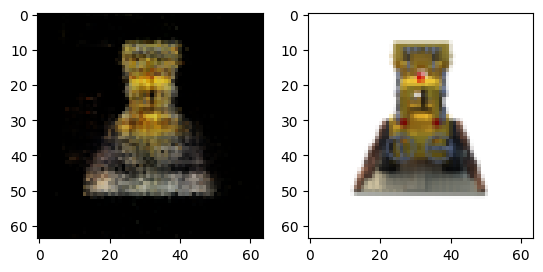

In [10]:
def run_test():
  with torch.no_grad():
    new_size = 64
    image, cam_2_world = dataset[0]
    image = image.to(device)
    cam_2_world = cam_2_world.to(device)

    t, d = stratified_sampling()
    rays_o, rays_d = get_rays(cam_2_world, width=new_size, height=new_size)

    rays_o = rays_o.unsqueeze(-1).expand(*rays_o.shape, t.shape[0])
    rays_d = rays_d.unsqueeze(-1).expand(*rays_d.shape, t.shape[0])
    print(rays_o.device, rays_d.device, t.device)
    ray_positions = rays_o + rays_d * t

    color, sigma = model(
        ray_positions, 
        rays_d, 
    )

    color = color.permute(3, 0, 1, 2)
    alpha = 1 - torch.exp(-sigma * d)

    transmittance = torch.cumprod(1 - alpha, dim=-1) / (1 - alpha + 1e-10)
    x = torch.sum(transmittance * alpha * color, dim=-1).permute(1, 2, 0)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(x.cpu().numpy())
    # resize img to 128x128 with PIL package
    img = Image.open(f'lego/train/r_0.png')
    img = img.resize((new_size, new_size), Image.BILINEAR)

    ax[1].imshow(img)
    fig.show()

run_test()
  
